In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [34]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [3]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [4]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [5]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

In [28]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage

In [6]:
from langchain_openai import ChatOpenAI

In [7]:
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig

In [29]:
from langgraph.checkpoint.memory import MemorySaver
import json

memory = MemorySaver()

In [9]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
######### 2. 도구 정의 및 바인딩 #########

search_tool = TavilySearch(max_results=1)

In [12]:
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=1)

In [13]:
tools = [search_tool, search_keyword]

In [14]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [15]:
llm_with_tools = llm.bind_tools(tools)

In [16]:
def chatbot(state: State):
    print(f'=='*50)
    print('===== chatbot() 함수 시작 =====')
    print(f"chatbot() 으로 넘어온 메시지 :")
    print(state['messages'])
    print(f"메시지 개수 : {len(state['messages'])}")
    print()

    answer = llm_with_tools.invoke(state['messages'])

    print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    print(f'[도구 사용 LLM 실행 결과 answer]: {answer}')
    print(f'[도구 사용 LLM 실행 결과 additional_kwargs]: {answer.additional_kwargs}')

    print('===== chatbot() 함수  끝 =====')
    print(f'=='*50)
    print()

    return {'messages': [answer]}

In [17]:
graph_builder = StateGraph(State)

In [18]:
graph_builder.add_node('chatbot', chatbot)

In [19]:
tool_node = ToolNode(tools=[search_tool, search_keyword])

In [20]:
graph_builder.add_node('tools', tool_node)

In [21]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [22]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [23]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [24]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [25]:
graph = graph_builder.compile(checkpointer=memory)

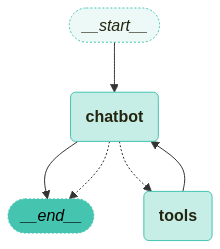

In [26]:
visualize_graph(graph)

In [27]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

thread_id: 20ac14


In [30]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 뉴스 검색을 해주세요')

i = 1

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('===== 여기서 시작 =====')
    print(f'[event] 바깥 for 시작 {i}')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            # print(f"additional_kwargs: {value['messages'][-1].additional_kwargs}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] value content: {value['messages'][-1].content}")
            # print(f"addtional_kwargs: {value['messages'][-1].additional_kwargs}")

            if 'tool_calls' in value['messages'][-1].additional_kwargs:
                # print(f"additional_kwargs tool_calls: {value['messages'][-1].additional_kwargs['tool_calls']}")
                tool_calls = value['messages'][-1].additional_kwargs['tool_calls']

                for call in tool_calls:
                    if 'function' in call:
                        arguments = json.loads(call['function']['arguments'])
                        name = call['function']['name']

                        print(f"도구 이름 : {name}")
                        print(f"Arguments: {arguments}")
            else:
                print("additional_kwargs tool_calls: None")
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    i=i+1
    
    print('===== 여기서 끝 =====') 
    print()
print(f'전체 반복문 {i}번 실행')    

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='랭체인에 대해서 뉴스 검색을 해주세요', additional_kwargs={}, response_metadata={}, id='dca47e35-1806-4334-a763-bf56f90a10a7')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_6pi4KLEIfev01hYtmnTvSVO0', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 122, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-08d58ec4-eef3-4aa8-8bc4-de89fe34a6f7-0' tool_calls=[{'name': 'search_keyword', 'args': {'query': '랭체인'}, 'id

In [31]:
thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 뉴스 검색을 해주세요')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    for value in event.values():
        value["messages"][-1].pretty_print()

thread_id: f07b93
===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='랭체인에 대해서 뉴스 검색을 해주세요', additional_kwargs={}, response_metadata={}, id='63b45b15-cad3-4d88-ade2-b5b292f8fe8c')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_QySYg5qsCxD8OXp3dNbklm2R', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 122, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-123ab1d6-31ba-45e6-a766-55422e2582c9-0' tool_calls=[{'name': 'search_keyword', 'args': {'q

In [32]:
question = ('랭체인에 대해서 웹 검색을 해주세요')

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print('==' * 50)
    print('[event]')
    # print(event)

    for key, value in event.items():
        value['messages'][-1].pretty_print()

===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='랭체인에 대해서 뉴스 검색을 해주세요', additional_kwargs={}, response_metadata={}, id='63b45b15-cad3-4d88-ade2-b5b292f8fe8c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QySYg5qsCxD8OXp3dNbklm2R', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 122, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-123ab1d6-31ba-45e6-a766-55422e2582c9-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '랭체인'}, 'id': 'call_QySYg5qsCxD8OXp3dNbklm2R', 'type': 'tool_ca

In [33]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id}
)

question = ('랭체인에 대해서 웹 검색을 해주세요')

i = 1

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print()
    print('===== 여기서 시작 =====')
    print(f'[event] 바깥 for 시작 {i}')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print()

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            # print(f"[해당 노드 값] content: {value['messages'][-1].content}")
            # print(f"additional_kwargs: {value['messages'][-1].additional_kwargs}")
            print('==================== END HumanMessage ====================')
            print()
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            print(f"[해당 노드 값] value content: {value['messages'][-1].content}")
            # print(f"addtional_kwargs: {value['messages'][-1].additional_kwargs}")

            if 'tool_calls' in value['messages'][-1].additional_kwargs:
                # print(f"additional_kwargs tool_calls: {value['messages'][-1].additional_kwargs['tool_calls']}")
                tool_calls = value['messages'][-1].additional_kwargs['tool_calls']

                for call in tool_calls:
                    if 'function' in call:
                        arguments = json.loads(call['function']['arguments'])
                        name = call['function']['name']

                        print(f"도구 이름 : {name}")
                        print(f"Arguments: {arguments}")
            else:
                print("additional_kwargs tool_calls: None")
            print('==================== END AIMessage ====================')    

        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            # print(f"[해당 노드 값] value : \n{value['messages'][-1]}")
            content = json.loads(value['messages'][-1].content)

            if content and isinstance(content, list) and len(content) > 0:
                print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")
            else:
                print("No content or invalid content format in ToolMessage")

            print('==================== END ToolMessage ====================')   

        print()
        
    print('바깥 for 끝')
    i=i+1
    
    print('===== 여기서 끝 =====') 
    print()
print(f'전체 반복문 {i}번 실행')    

thread_id: f165dd
===== chatbot() 함수 시작 =====
chatbot() 으로 넘어온 메시지 :
[HumanMessage(content='랭체인에 대해서 웹 검색을 해주세요', additional_kwargs={}, response_metadata={}, id='c5c4bd37-5c8a-42ba-afc3-d19682f8d4af')]
메시지 개수 : 1

[도구 사용 LLM 실행 결과 content]: 
[도구 사용 LLM 실행 결과 answer]: content='' additional_kwargs={'tool_calls': [{'id': 'call_8iYGPvY509jWNfFtgboAyC1m', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'tavily_web_search'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 122, 'total_tokens': 143, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3267753c5d', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-95c72143-0a79-46ca-ad58-0e583f02acde-0' tool_calls=[{'name': 'tavily_web_search', 'args'